In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets
from torchvision.transforms import ToTensor

from tqdm.auto import tqdm
import random
import sys

In [2]:
# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
# Mount drive to avoid having to reupload helper_functions.py
from google.colab import drive
drive.mount("/content/drive")

# Add  location
sys.path.append("/content/drive/My Drive/Colab Notebooks/Deep_Learning_SU/Paper_Implementations/VAE")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Import helper_functions
from helper_functions import show_single_image, show_reconstruction_results, show_images_row, plot_latent_space

## 1. Get data - we will be using the MNIST dataset

In [5]:
# Define transform
simple_transform = ToTensor()

In [6]:
# Get data
train_data = datasets.MNIST(
    root = "data",
    train = True,
    download = True,
    transform =  simple_transform,
    target_transform = None
)
test_data = datasets.MNIST(
    root = "data",
    train = False,
    download = True,
    transform = simple_transform
)

In [7]:
# Check length
len(train_data), len(test_data)

(60000, 10000)

In [8]:
# Check first sample of train data
image, label = train_data[0]
print(f"Shape of image is : {image.shape} [channels, height, width]")
print(f"Image tensor dtype is :{image.dtype}")
print(f"Label is {label}")

Shape of image is : torch.Size([1, 28, 28]) [channels, height, width]
Image tensor dtype is :torch.float32
Label is 5


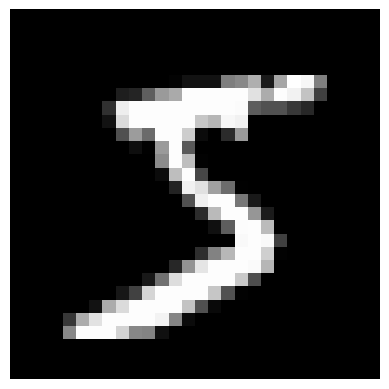

In [9]:
# Show first training sample
show_single_image(image)

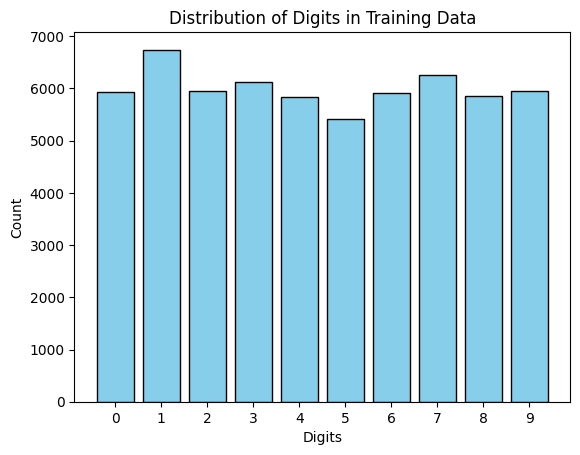

In [10]:
# Check digit distribution in training data
# Count the occurrences of each class in the target variable
classes, counts = np.unique(train_data.targets, return_counts = True)

# Create the bar chart
plt.bar(classes, counts, color = "skyblue", edgecolor = "black")

# Add title and labels
plt.title("Distribution of Digits in Training Data")
plt.xlabel("Digits")
plt.ylabel("Count")

# Set x-ticks for clarity
plt.xticks(classes)
plt.gca().xaxis.set_ticks_position("bottom")
plt.gca().yaxis.set_ticks_position("left")

plt.show()

In [11]:
# Create train dataloader
train_dataloader = DataLoader(train_data, batch_size = 32, shuffle = False)

## 2. AutoEncoder - we start with a basic AutoEncoder

The AutoEncoder is only trained on the reconstruction loss, there are no constraints imposed on the latent space.

In [12]:
class AutoEncoder(nn.Module):
    def __init__(self, latent_size = 8, image_size=(1, 28, 28)):
        super().__init__()

        # Set the size of the latent dimension
        self.latent_size = latent_size

        self.image_size = image_size

        # Define the encoder
        self.encoder = nn.Sequential(
            nn.Flatten(), # flattens [batch_size, 1, 28, 28] to [batch_size, 784]
            nn.Linear(in_features = 784, out_features = 256),
            nn.ReLU(),
            nn.Linear(in_features = 256, out_features = self.latent_size)
        )

        self.decoder = nn.Sequential(
            nn.Linear(in_features = self.latent_size, out_features = 256),
            nn.ReLU(),
            nn.Linear(in_features = 256, out_features = 784),
            nn.Sigmoid() # use sigmoid to normalize output between 0, 1
        )

    def forward(self, x):
        # Pass the input through the encoder
        latent = self.encoder(x)
        # Pass the latent representation through the decoder
        decoded = self.decoder(latent)
        # Restore output to image form
        decoded = decoded.view(x.size(0), 1, 28, 28)
        # Return both the latent representation and the reconstructed image
        return latent, decoded

    def encode(self, x):
        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            # Use only encoder
            return self.encoder(x)

    def decode(self, z):
        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            # Use only decoder
            decoded = self.decoder(z)
            decoded_img = decoded.view(z.size(0), 1, 28, 28)
            return decoded_img

In [13]:
# Instantiate the autoencoder
model_v1 = AutoEncoder(latent_size = 8)
model_v1.to(device)

# Define loss and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_v1.parameters(), lr = 3e-3)

In [14]:
epochs = 5
# Training Loop
for epoch in tqdm(range(epochs)):
    total_loss = 0
    for batch_idx, (inputs, _) in enumerate(train_dataloader):
        # Send data to device
        inputs = inputs.to(device)

        # Forward pass
        latent, decoded = model_v1(inputs)

        # Compute loss
        loss = loss_fn(decoded, inputs)

        # Zero the gradient
        optimizer.zero_grad()

        # Backprop
        loss.backward()

        # Updata parameters
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)

    epoch_loss = total_loss/ len(train_dataloader.dataset)
    print(
        "Epoch {}/{}: loss = {:.4f}".format(epoch + 1, epochs, epoch_loss)
    )

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5: loss = 0.0280
Epoch 2/5: loss = 0.0218
Epoch 3/5: loss = 0.0206
Epoch 4/5: loss = 0.0199
Epoch 5/5: loss = 0.0194


In [15]:
# Freze model
for parameter in model_v1.parameters():
    parameter.requires_grad = False

In [16]:
# Take five random images from the training data
torch.manual_seed(42)

five_random_images = []
for i in range(5):
    random_idx = torch.randint(0, len(train_data), size = [1]).item()
    img, _ = train_data[random_idx]
    five_random_images.append(img)

# Check results
len(five_random_images)

5

In [17]:
# Function to create reconstructions
def create_reconstructions(model, images, vae = False):
    num_images = len(images)
    if num_images != 1:
        # Stack images
        img_batch = torch.stack(images)
    else:
        img_batch = images.unsqueeze(dim = 0)
    # Set model to eval
    model.eval()
    with torch.inference_mode():
        if not vae:
            _, reconstructions = model_v1(img_batch)
        else:
            reconstructions, mu, logvar = model(img_batch)

    reconstructions = torch.unbind(reconstructions, dim = 0)
    return reconstructions

reconstructions = create_reconstructions(model_v1, five_random_images)

Let us check the reconstructions of the trained Autoencoder model plotting the originals above the reconstructions.

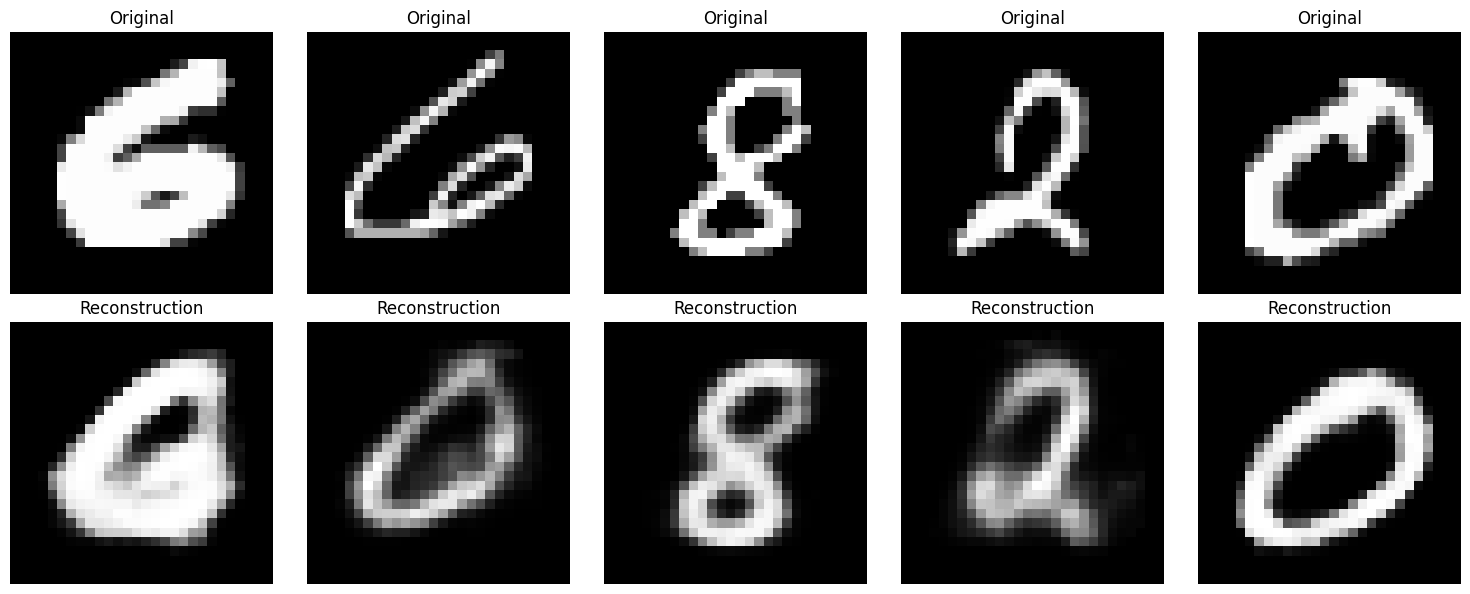

In [18]:
show_reconstruction_results(five_random_images, reconstructions)

Below we perform another experiment - altering pixels in an image to see if the autoencoder will "inpaint" the reconstruction.

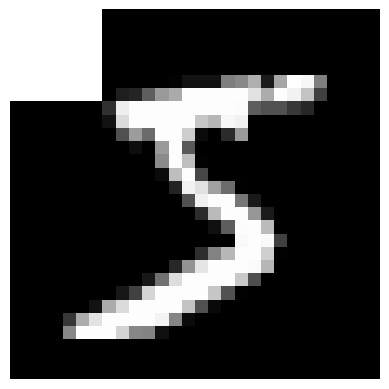

In [19]:
# Alter pixels in image
img, label = train_data[0]
img[:, :7, :7 ] = 1

# Show results
show_single_image(img)

In [20]:
reconstructions = create_reconstructions(model_v1, img)

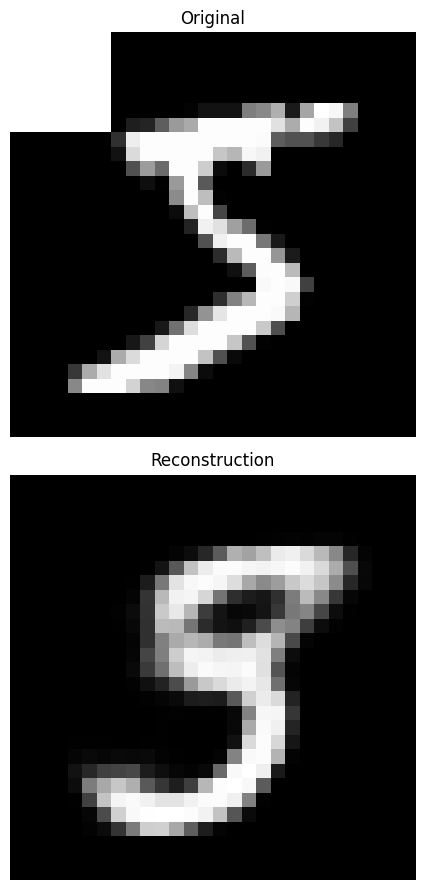

In [21]:
show_reconstruction_results([img], reconstructions)

The Autoencoder did repaint the pixels we altered, however the reconstrucion looks more like a 3 than a 5. Let us try changing a larger area of pixels and see what happens.

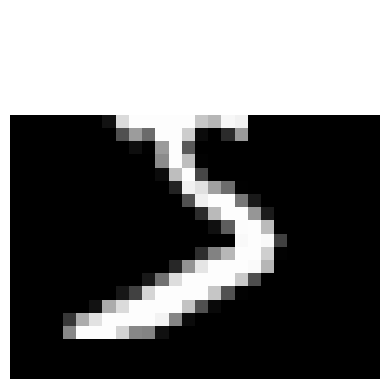

In [22]:
# Alter pixels in image
img, label = train_data[0]
img[:, :8, :28 ] = 1

# Show results
show_single_image(img)

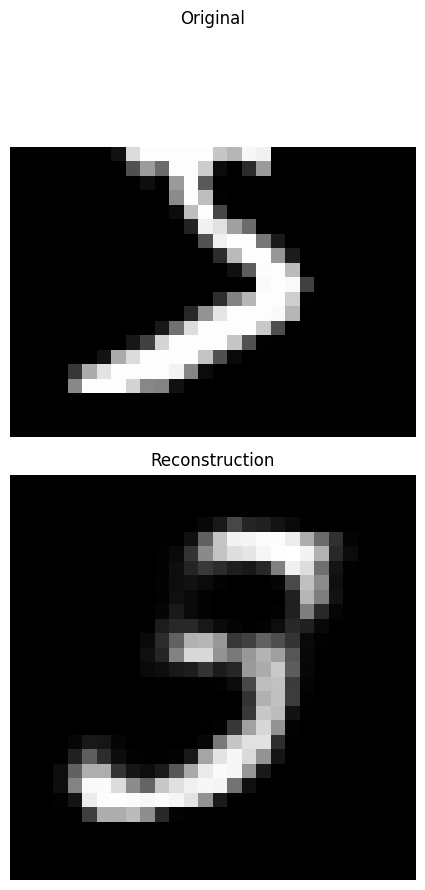

In [23]:
reconstructions = create_reconstructions(model_v1, img)
show_reconstruction_results([img], reconstructions)

When we destroy too much information in the original image, the model gets confused and can output a different image.

Now, once the Autoencoder is trained ideally we would like to be able to sample new data from it, that is start with a latent space vector and use the decoder only. Let us see how this goes.

In [24]:
# Set seed
torch.manual_seed(42)
# Create a random latent space tensor
random_z = torch.randn(5, 1, 8)

# Pass the random latent to the autoencoder to decode
random_z_decoded = model_v1.decode(random_z)

In [25]:
# Check type and shape of decoded latent space vectors as a sanity check
print(f"Decoder output is of type: {type(random_z_decoded)}")
print(f"Output shape is {random_z_decoded.shape}")

Decoder output is of type: <class 'torch.Tensor'>
Output shape is torch.Size([5, 1, 28, 28])


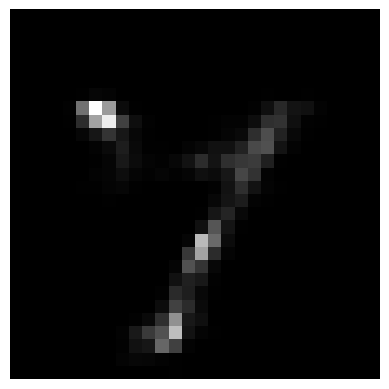

In [26]:
first_decoded_random_z = torch.unbind(random_z_decoded)[0]
show_single_image(first_decoded_random_z)

The result is not great, let us check the other reconstructions as well.

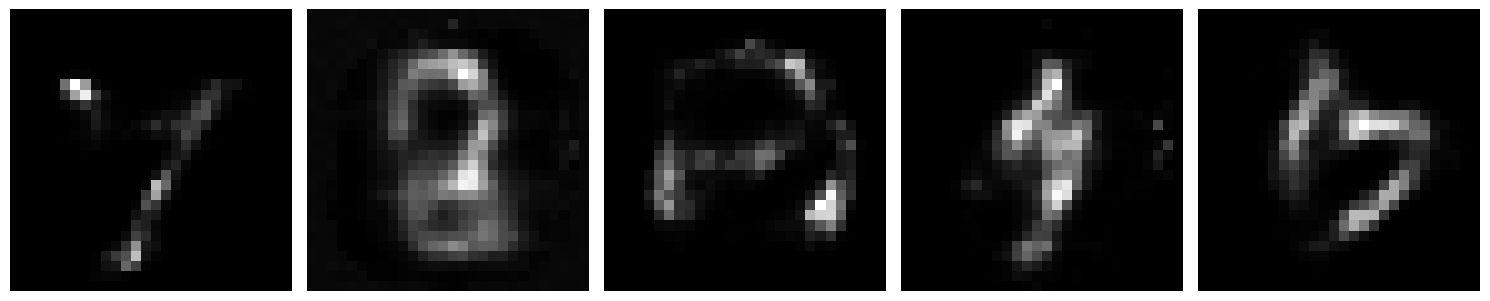

In [27]:
show_images_row(random_z_decoded)

When starting with a latent vector and using only the decoder, most of the reconstructions do not resemble the original dataset much. This is because the only objective function for the Autoencoder we trained is the Mean Squared Error(MSE). It is only trying to optimize the parameters with the purpose of achieving output as close to the original data point as possible. This places no constraints on the latent space and it is not organized in a way we would like. Namely, it contains many "holes" - points in the latent space that are not mapped to a meaningful output. This is were the Variational Autoencoder comes in. In the VAE, we add another term to the objective function to regularize the model and effectively pack the latent space close to the origin, removing the "holes" which prevent us from generationg new samples.

## 3. Variational AutoEncoder(VAE)

In [28]:
class Encoder(nn.Module):
    def __init__(self, input_dim = 784, mid_dim_size = 256, latent_size = 8):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features = input_dim, out_features = mid_dim_size)
        self.ReLU = nn.ReLU()
        self.fc2_mu = nn.Linear(in_features = mid_dim_size, out_features = latent_size)
        self.fc2_logvar = nn.Linear(in_features = mid_dim_size, out_features = latent_size)

    def forward(self, x):
        x = self.flatten(x)
        x = self.ReLU(self.fc1(x))
        mu = self.fc2_mu(x)
        logvar = self.fc2_logvar(x)
        return mu, logvar

In [29]:
class Decoder(nn.Module):
    def __init__(self, output_dim = 784, mid_dim_size = 256, latent_size = 8):
        super().__init__()
        self.fc1 = nn.Linear(in_features = latent_size, out_features = mid_dim_size)
        self.ReLU = nn.ReLU()
        self.fc2 = nn.Linear(in_features = mid_dim_size, out_features = output_dim)

    def forward(self, z):
        z = self.ReLU(self.fc1(z))
        decoded = torch.sigmoid(self.fc2(z))
        reconstruction = decoded.view(decoded.size(0), 1, 28, 28)
        return reconstruction

In [30]:
class VAE(nn.Module):
    def __init__(self, input_dim = 784, mid_dim_size = 256, output_dim = 784, latent_size = 8):
        super().__init__()
        self.encoder = Encoder(input_dim = input_dim, mid_dim_size = mid_dim_size, latent_size = latent_size)
        self.decoder = Decoder(output_dim = output_dim, mid_dim_size = mid_dim_size, latent_size = latent_size)
        self.latent_size = latent_size

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        reconstruction = self.decoder(z)
        return reconstruction, mu, logvar

    def sample(self, num_samples, seed = None):
        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            if seed is not None:
                torch.manual_seed(seed)
                if torch.cuda.is_available():
                    torch.cuda.manual_seed_all(seed)
            # Generate random latent vector
            z = torch.randn(num_samples, self.latent_size, requires_grad = False).to(device)
            # Pass random latents through decoder
            samples = self.decoder(z)
        # return generations
        return samples

    def sample_with_latent_variation(self, num_samples,  variation_index = 0, variation_step = 0.1, seed = None):
        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            if seed is not None:
                torch.manual_seed(seed)
                if torch.cuda.is_available():
                    torch.cuda.manual_seed_all(seed)
            z = torch.randn(1, self.latent_size, requires_grad=False).to(device)
            z = z.repeat(num_samples, 1)  # Create num_samples copies of the initial latent vector

            variations = torch.arange(0, num_samples, dtype = torch.float32, device = device) * variation_step
            z_varied = z.clone()
            z_varied[:, variation_index] += variations

            samples = self.decoder(z_varied)

        return samples

    def sample_with_given_latents(self, latent_tensors):
        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            # Pass given latent tensors through decoder
            samples = self.decoder(latent_tensors.to(device))
        return samples


In [31]:
def loss_function_vae(reconstruction, x, mu, logvar, alpha = 1, beta = 3):
    # Compute reconstrucion loss
    BCE = nn.functional.binary_cross_entropy(reconstruction, x, reduction = "sum")
    # Compute KL divergence loss
    KLD = - 0.5 * torch.sum(1 + logvar - mu.pow(2)- logvar.exp())
    return alpha * BCE + beta * KLD

In [32]:
# Instantiate the VAE
model_v2 = VAE(latent_size = 8)
model_v2.to(device)

# Set the optimizer and learning rate
optimizer = torch.optim.Adam(model_v2.parameters(), lr = 3e-3)

In [33]:
def train_vae(model, train_dataloader, loss_fn, optimizer, num_epochs):
    for epoch in tqdm(range(num_epochs)):
        total_loss = 0.0
        for batch_idx, (inputs, _) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            # Forward pass
            reconstruction, mu, logvar = model(inputs)

            # Compute loss
            loss = loss_function_vae(reconstruction = reconstruction, x = inputs,
                                     mu = mu, logvar = logvar)

            # Zero the gradient
            optimizer.zero_grad()

            # Backpropagation
            loss.backward()

            # Update parameters
            optimizer.step()

            # Update the running loss
            total_loss += loss.item() * inputs.size(0)

        # Print the epoch loss
        epoch_loss = total_loss / len(train_dataloader.dataset)
        print(
            "Epoch {}/{}: loss={:.4f}".format(epoch + 1, num_epochs, epoch_loss)
        )

In [34]:
train_vae(model = model_v2, train_dataloader = train_dataloader, loss_fn = loss_function_vae, optimizer = optimizer,  num_epochs = 20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20: loss=5101.0030
Epoch 2/20: loss=4728.2108
Epoch 3/20: loss=4655.1964
Epoch 4/20: loss=4621.5704
Epoch 5/20: loss=4595.1879
Epoch 6/20: loss=4583.4203
Epoch 7/20: loss=4567.9924
Epoch 8/20: loss=4559.4438
Epoch 9/20: loss=4547.6252
Epoch 10/20: loss=4544.0012
Epoch 11/20: loss=4538.2319
Epoch 12/20: loss=4531.5635
Epoch 13/20: loss=4525.2020
Epoch 14/20: loss=4521.3598
Epoch 15/20: loss=4523.0031
Epoch 16/20: loss=4515.1017
Epoch 17/20: loss=4511.5213
Epoch 18/20: loss=4508.6354
Epoch 19/20: loss=4509.2563
Epoch 20/20: loss=4505.6682


The loss value is this high because BCE compares differences per pixel and it adds up.

Below, we show the results of reconstructing random samples from the training set with the trained variational autoencoder:

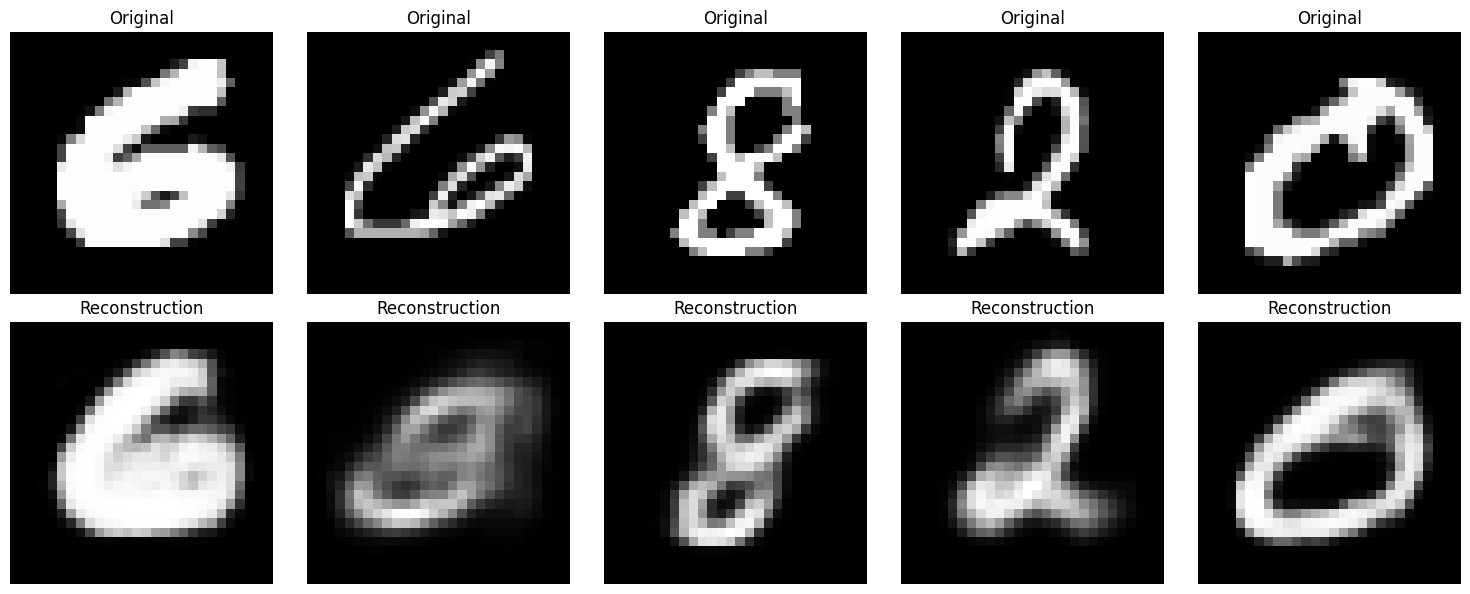

In [35]:
reconstructions = create_reconstructions(model_v2, five_random_images, vae = True)
show_reconstruction_results(images = five_random_images, reconstructions = reconstructions)

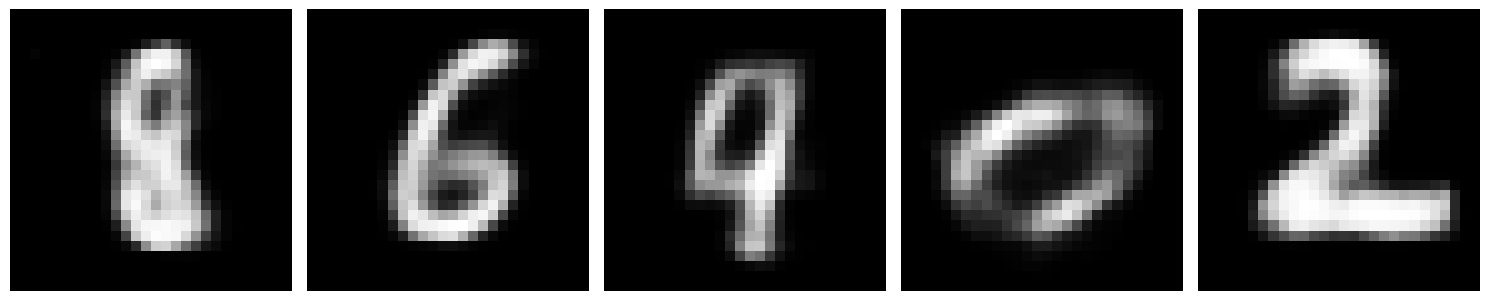

In [69]:
# Generate samples from random latents
generations = model_v2.sample(5, seed = 34)
# Show results
show_images_row(generations)

Below we show what happens with the reconstructions when we vary one dimension of a the latent vector while freezing the rest.

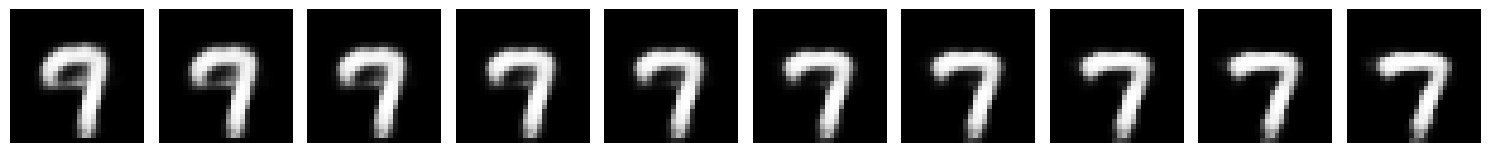

In [55]:
# Vary dimensions 0 while freezing the rest
samples = model_v2.sample_with_latent_variation(
    num_samples = 10,
    variation_index = 0,
    variation_step = 0.2,
    seed = 51
)
show_images_row(samples)

In a final experiment, we train a VAE where the latent space is two dimensional to be able to be able to visualize it on a 2D plot.

In [38]:
# Instantiate the VAE
model_v3 = VAE(latent_size = 2)
model_v3.to(device)

optimizer = torch.optim.Adam(model_v3.parameters(), lr = 3e-3)

In [39]:
# Train the 2d latent space VAE
train_vae(model = model_v3, train_dataloader = train_dataloader, loss_fn = loss_function_vae, optimizer = optimizer,  num_epochs = 10)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1/15: loss=5760.7289
Epoch 2/15: loss=5509.0512
Epoch 3/15: loss=5446.5474
Epoch 4/15: loss=5404.1756
Epoch 5/15: loss=5371.3185
Epoch 6/15: loss=5346.5018
Epoch 7/15: loss=5326.1827
Epoch 8/15: loss=5313.4666
Epoch 9/15: loss=5299.6807
Epoch 10/15: loss=5289.6877
Epoch 11/15: loss=5281.3610
Epoch 12/15: loss=5273.6520
Epoch 13/15: loss=5268.2238
Epoch 14/15: loss=5262.5733
Epoch 15/15: loss=5254.6642


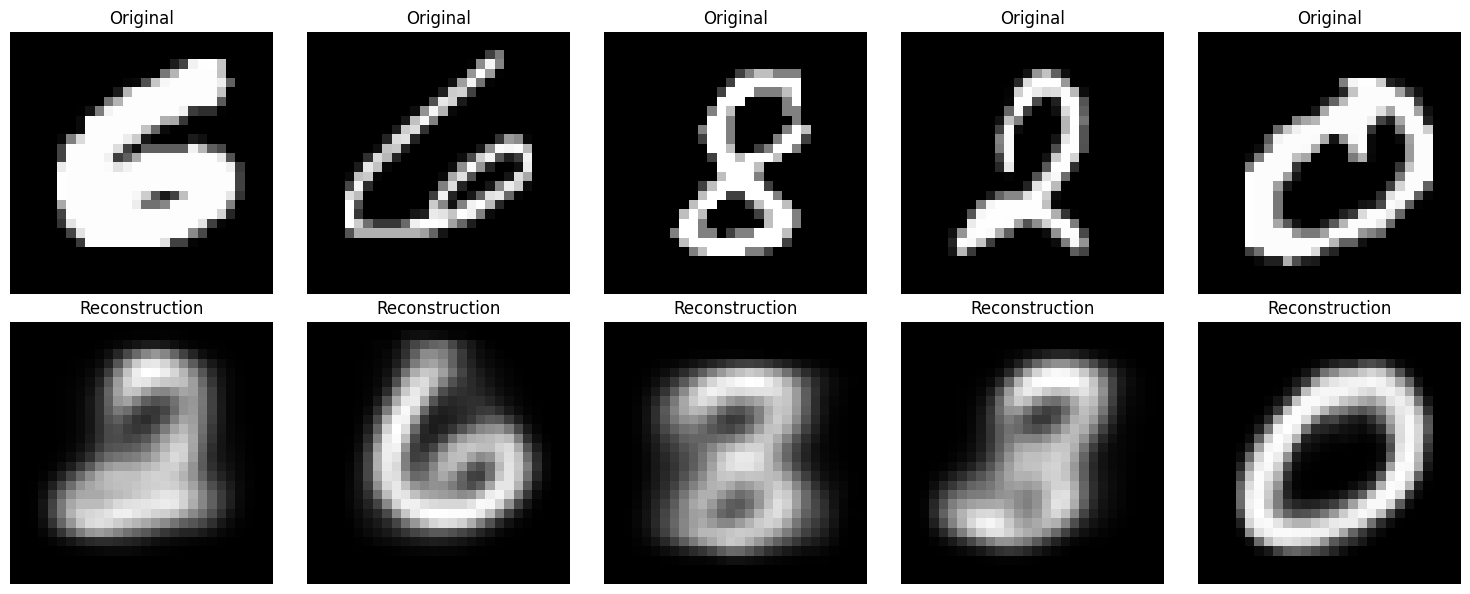

In [40]:
# Show reconsructions for the 2d latent space VAE
reconstructions = create_reconstructions(model_v3, five_random_images, vae = True)
show_reconstruction_results(images = five_random_images, reconstructions = reconstructions)

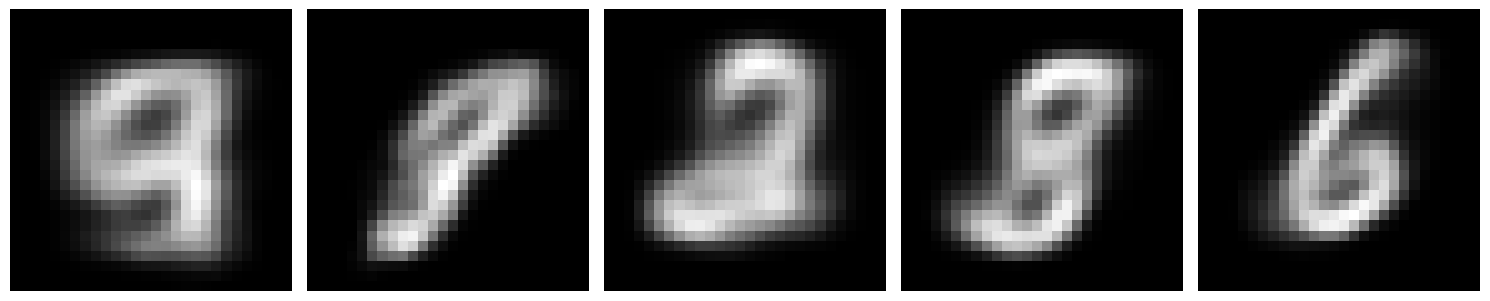

In [41]:
# Check generations of the 2d latent space VAE
# Generate samples from random latents
generations = model_v3.sample(5)
# Show results
show_images_row(generations)

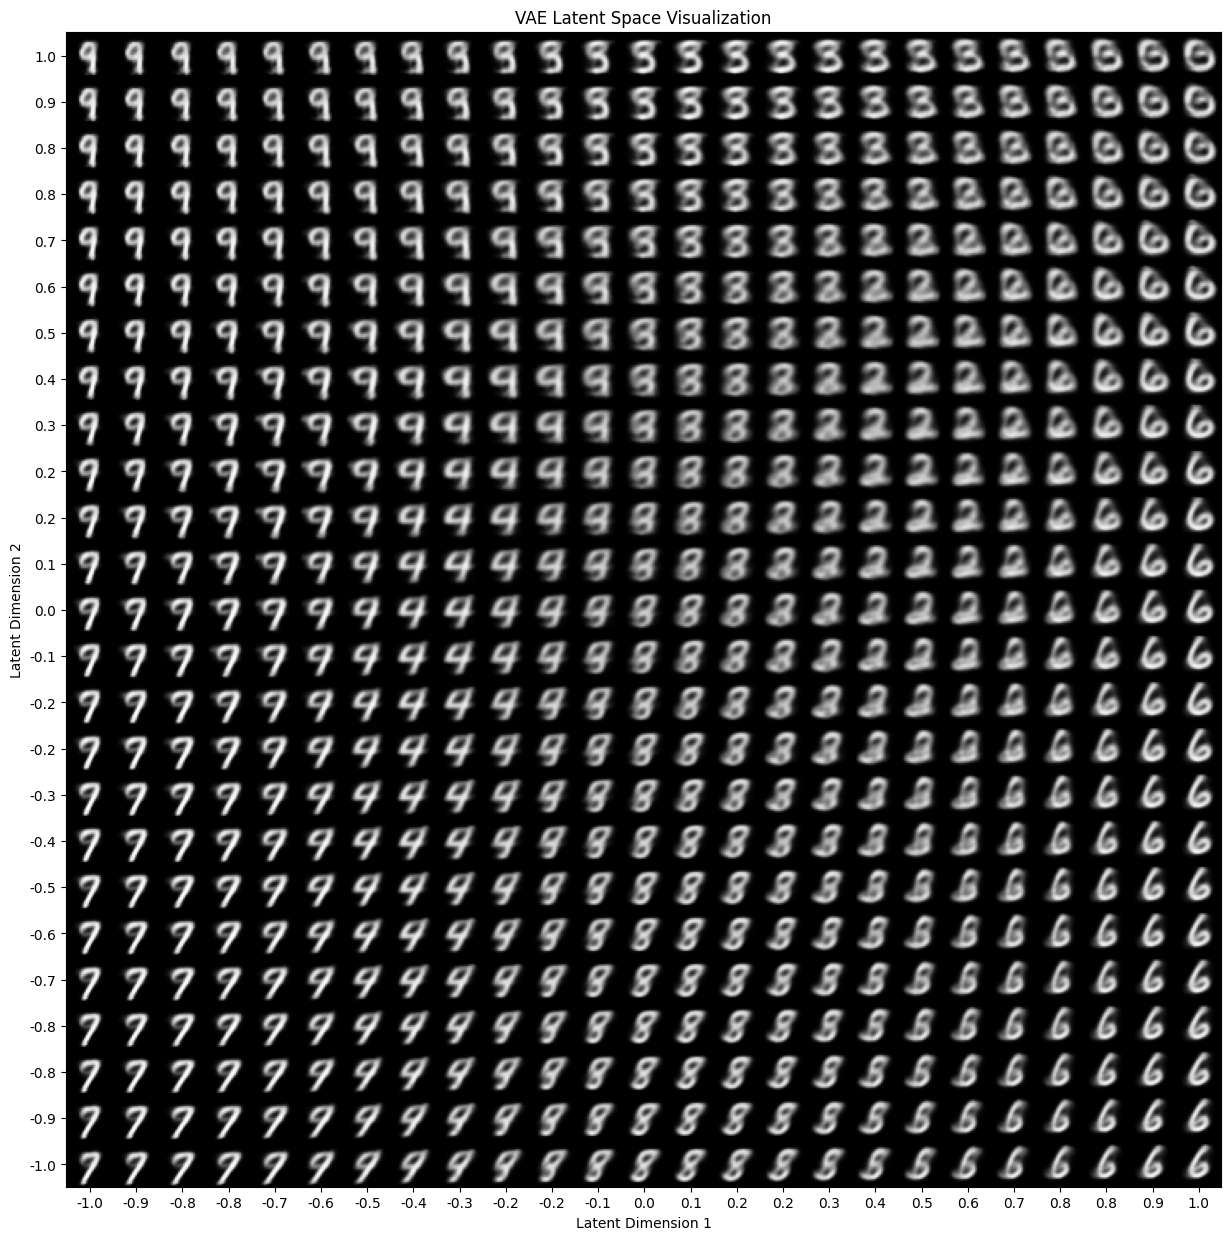

In [42]:
plot_latent_space(model_v3)